In [3]:
import tpknnsource as tpsource
import numpy as np
from sklearn.neighbors import KNeighborsClassifier 
from math import sqrt
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import linear_model

# Génération artificielle des données

### 1)

Étudiez les fonctions rand_bi_gauss, rand_tri_gauss, rand_clown et rand_checkers. Que renvoient ces fonctions ? À quoi correspond la dernière colonne ? Générez les données en utilisant chaque de ces 4 fonctions avec les paramètres du corrigé du TP1 (pour rand_checkers prenez 150 pour les deux premiers arguments ; pour rand_tri_gauss générez 50 observations dans chaque classe, centrées en (1, 1) > , (−1, −1) > et (1, −1) > , tous les écart-types égaux à 0.9). On va nommer ces jeux de données #1, #2, #3 et #4, respectivement.

In [20]:
# classification linéaire
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X1, y1 = tpsource.rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)

In [21]:
# classification linéaire
X2, y2 = tpsource.rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.9, 0.9],
                   sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])

In [22]:
# classification peu linéaire
n1 = 50
n2 = 50
sigmas1 = 1.
sigmas2 = 5.
X3, y3 = tpsource.rand_clown(n1, n2, sigmas1, sigmas2)

In [70]:
# classification non linéaire
n1 = 150
n2 = 150
sigma = 0.1
X4, y4 = tpsource.rand_checkers(n1, n2, sigma)

### 2)

Utilisez la fonction plot_2d afin d’afficher les jeux de données générés avec chacune des fonctions.

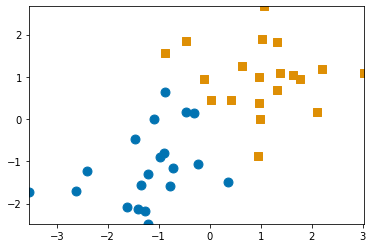

In [24]:
# rand_bi_gauss --> 2 classes (y prend 2 valeurs différentes)
tpsource.plot_2d(X1,y1)

Visuellement, les observations se séparent bien. On pourrait donc appliquer une classification linéaire.

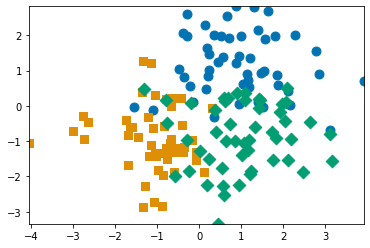

In [25]:
# rand_tri_gauss --> 3 classes
tpsource.plot_2d(X2,y2)

Même observation qu'au graphe précédent

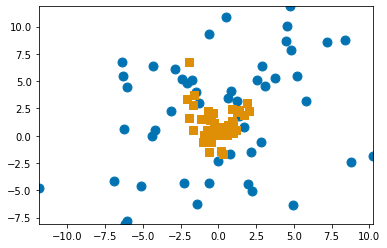

In [26]:
# clown
tpsource.plot_2d(X3,y3)

Les observations sont difficilement classifiables visuellement, il sera donc difficile d'appliquer un algorithme de classification linéaire.

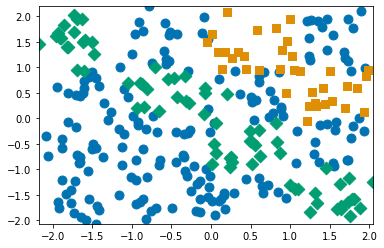

In [71]:
# rand_checkers
tpsource.plot_2d(X4,y4)

Même conclusion qu'au graphe précédent

# KNN

### 3)

Proposez une version adaptée de cette méthode pour la régression, i.e., quand les observations y
sont à valeurs réelles : $\mathcal{Y} = \mathbb{R}$.

Pour appliquer l'algorithme des kppv dans le cas d'une régression ($\mathcal{Y} \in \mathbb{R}$), on peut utiliser la moyenne des points d'une observation pour définir son rang.

### 4)

Écrivez votre propre classe KNNClassifier avec les méthodes d’apprentissage fit et de classification predict. Choisissez une stratégie de traitement des ex aequo, c’est-à-dire des points avec la même distance ou le même nombre de points de chaque classe dans V k (x). Vérifier la validité des résultats en les comparant à ceux de la classe KNeighborsClassifier de scikit-learn en utilisant le jeu de données #2. Vous proposerez votre propre méthode de comparaison (par exemple, en utilisant les observations d’indice pair pour le set d’apprentissage et celles d’indice impair pour le set de test).

In [28]:
# calcul de la distance euclidienne entre 2 vecteurs
def euclidean_distance(v1, v2):
    distance = 0.0
    for i in range(len(v1)):
        distance += (v1[i] - v2[i])**2
    return sqrt(distance)

In [29]:
def getBestClass(dic):
    sorted_dic = sorted(dic.items(), key=lambda kv: kv[1], reverse=True) # Tri sur les valeurs (nombre d'occurences)
    return sorted_dic[0][0]
# NB: en cas d'égalité, l'ordre des indices dans l'output est le même
# qu'en input, c'est-à-dire ici l'ordre d'apparition de la première classe pour une colonne

In [30]:
def getBestClassFromCount(sorted_idx, y_train):
    n = sorted_idx.shape[0]
    m = sorted_idx.shape[1]
    y_pred=[]
    for j in range(m):
        dic={}
        for i in range(n):
            class_tmp = y_train[sorted_idx[i,j]]
            if (class_tmp in dic):
                dic[class_tmp]=dic[class_tmp]+1
            else:
                dic[class_tmp]=1
        y_pred.append(getBestClass(dic))
    return y_pred

In [31]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import metrics

class KNNClassifier(BaseEstimator, ClassifierMixin):
    """ Homemade kNN classifier class """
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y): # L'entraînement sert simplement à "enregistrer" les données d'entraînement,
                         # déjà classifiées
        self.X = X
        self.Y = y
        return self
    
    def predict(self, X):
        n = len(self.X) # taille de l'échantillon dans X_train
        m = len(X) # taille de l'échantillon dans X_test
        dist_mat = []
        for i in range(n): # On boucle sur tous les éléments de l'échantillon d'entraînement
            dist_vect = []
            for j in range(m): # On boucle sur tous les éléments de l'échantillon de test
                dist_vect.append(euclidean_distance(self.X[i], X[j]))
            dist_mat.append(dist_vect) # len(dist_vect) = m (nb de features; toutes les distances pour une observation)
            
        dist_mat = np.asarray(dist_mat) # dist_mat.shape = (n,m); T_test en colonne, X_train en ligne
        
        # dist_mat = metrics.pairwise.pairwise_distances(X, Y=self.X, metric='euclidean', n_jobs=1)
            
        idx_sort = np.argsort(dist_mat, kind='mergesort', axis=0)  # idx_sort.shape = (n,m); dist_mat triée selon les colonnes
        # mergesort donne une gestion stable des nombre égaux: 
        # en cas d'égalité, l'ordre des indices dans l'output est le même que l'ordre dans l'input
        
        idx_sort_knn = idx_sort[:self.n_neighbors,:] # Redimensionnement avec le nombre de plus proches voisins
        return getBestClassFromCount(idx_sort_knn, self.Y) 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [33]:
clf = KNNClassifier(5)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [34]:
clf_2=KNeighborsClassifier(5)
clf_2.fit(X_train,y_train)
y_pred_2 = clf_2.predict(X_test)

In [35]:
print("Ressemblance entre les 2 méthodes de prédictions: {}".format(np.allclose(y_pred,y_pred_2)))
print("Erreur de prédiction: {}".format(np.sum(abs(y_pred_2-y_test))))

Ressemblance entre les 2 méthodes de prédictions: True
Erreur de prédiction: 12.0


On constate que les résultats obtenus manuellement ou avec <i>sklearn</i> sont similaires.

On aurait pu utiliser <i>metrics.pairwise.pairwise_distances</i> à la place de calculer la distance euclidienne manuellement.<br>
On aurait pu utiliser <i>stats.mode</i> pour avoir l'élément le plus fréquent des label.

# 5)

Faites tourner sur les quatre exemples de jeu de données cet algorithme de classification, en utilisant la distance euclidienne classique. Visualisez les règles de classification obtenues en utilisant la fonction frontiere_new. (Souvent, les autres choix de distance peuvent être utiles, par exemple la distance de Mahalanobis.)

In [36]:
clf_3=KNeighborsClassifier(5, metric='euclidean')
clf_3.fit(X_train,y_train)
y_pred_3 = clf_3.predict(X_test)

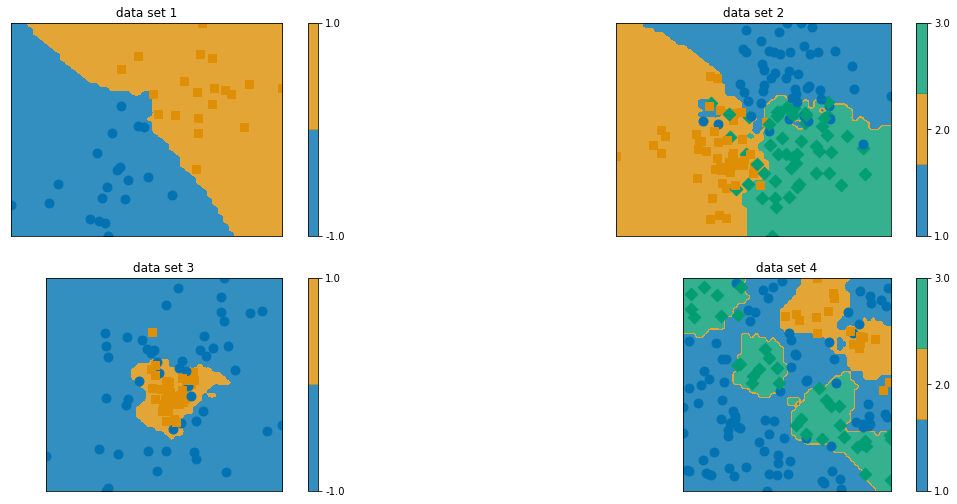

In [37]:
dataSetNb=1
plt.figure(figsize=(20, 18))
for X, y in [(X1, y1), (X2, y2), (X3, y3), (X4, y4)]:
    clf_ = KNeighborsClassifier(5)
    clf = clf_.fit(X, y)
    plt.subplot(4,2,dataSetNb)
    plt.title('data set {}'.format(dataSetNb))
    tpsource.frontiere_new(lambda x: clf.predict(x.reshape(1,-1)), X, y)
    dataSetNb+=1

# 6)

Pour les observations d’indice pair du jeu de données #2, faites varier le nombre k de voisins pris en compte : k = 1, 2, . . . , n. Que devient la méthode dans le cas extrême où k = 1 ? k = n ? Afficher ces cas sur les données étudiées en utilisant la fonction frontiere_new et présentez les dans une forme facilement lisible. Dans quels cas la frontière est-elle complexe ? simple ?

In [38]:
X2, y2 = tpsource.rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.9, 0.9],
                   sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

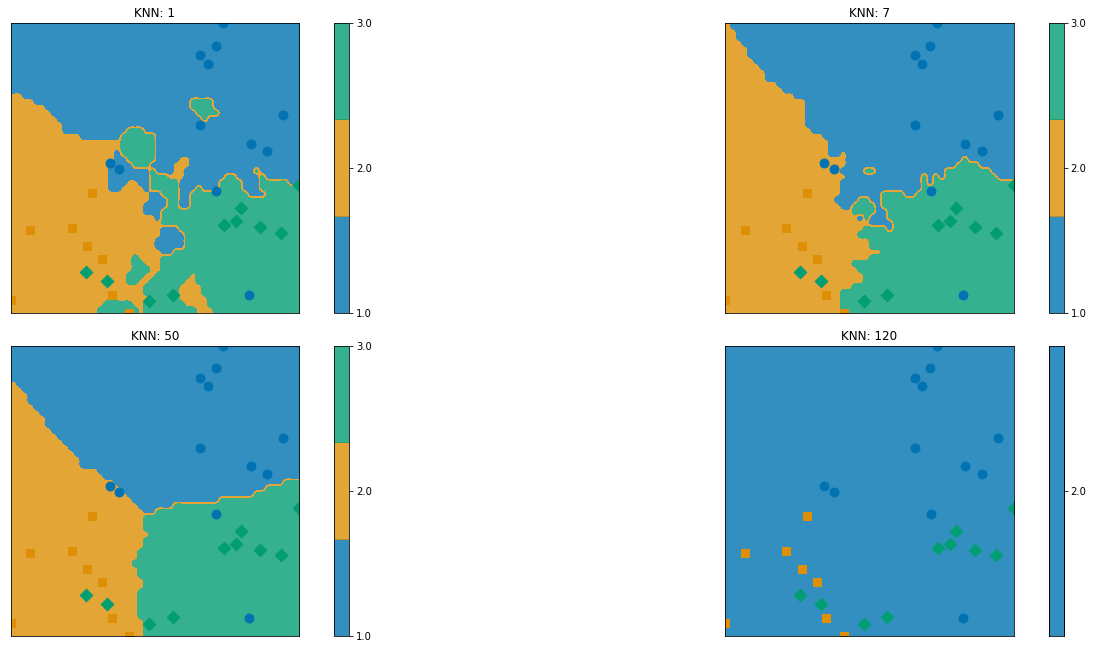

In [40]:
subplotNb=1
knn_list = [1,7,50,120]
plt.figure(figsize=(20, 18))
for k in knn_list:
    clf = KNeighborsClassifier(k)
    clf.fit(X_train, y_train)
    plt.subplot(4, 2, subplotNb)
    plt.title('KNN: {}'.format(k))
    tpsource.frontiere_new(lambda x: clf.predict(x.reshape(1,-1)), X_test, y_test)
    subplotNb+=1
plt.tight_layout()

On remarque que la frontière est complexe lorsque knn est 1, elle est simple lorsque knn est n. Intuitivement, cela est dû au fait qu'on diminue le degré de ressemblance lorsqu'on augmente ce paramètre.

# 7)

Une variante possible très utilisée consiste à pondérer les poids du jème voisin selon :
$$ w_{j}=\exp{(-\frac{d_{j}^{2}}{h})} $$
($h$ contrôlant le niveau de pondération)


Implémentez cette variante dans scikit-learn en passant le paramètre weights au constructeur
de KNeighborsClassifier. (Une autre possibilité consiste à pondérer les variable et non seule-
ment les observations, on le regarde pas ici.) On pourra s’inspirer de _weight_func de la partie
test de scikit-learn : https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/
neighbors/tests/test_neighbors.py Pour tester l’impact du choix de h sur les frontières de clas-
sification, visualisez les règles de classification pour k = 7 et h = 10 j avec j = −2, −1, 0, 1, 2 ; utilisez
les observations d’indice pair du jeux de données #2 pour l’entrainement du classifieur (Vous pouvez
utiliser la fonction frontiere_new.)

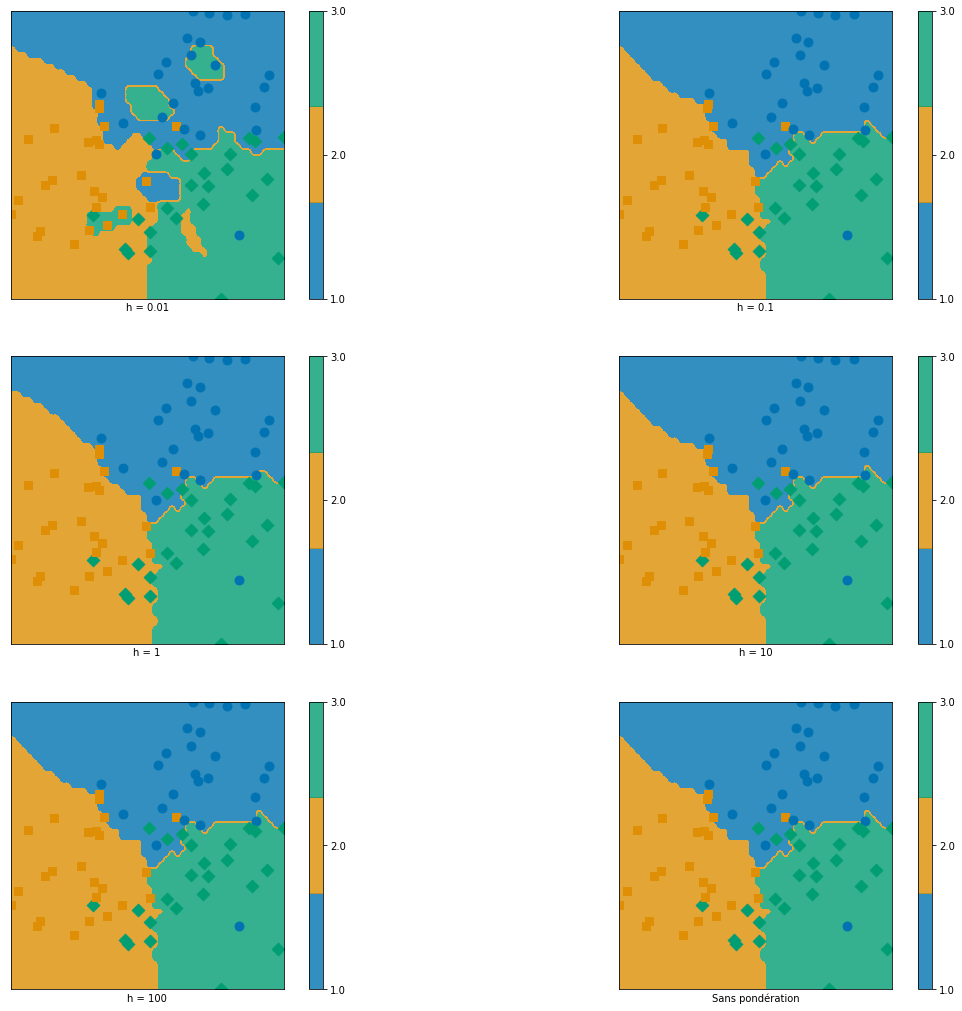

In [41]:
fig = plt.figure(figsize=(20, 18))

def weights(dist):
            h_ = 0.01
            w = np.exp(-dist**2/h_)
            return w
clf = KNeighborsClassifier(n_neighbors = 7, weights = weights )
clf.fit(X2[::2],y2[::2])
plt.subplot(3,2,1)  
plt.xlabel('h = 0.01')
tpsource.frontiere_new(lambda x: clf.predict(x.reshape(1,-1)), X2[1::2], y2[1::2])

def weights(dist):
            h_ = 0.1
            w = np.exp(-dist**2/100)
            return w
clf = KNeighborsClassifier(n_neighbors = 7, weights = weights )
clf.fit(X2[::2],y2[::2])
plt.subplot(3,2,2)  
plt.xlabel('h = 0.1')
tpsource.frontiere_new(lambda x: clf.predict(x.reshape(1,-1)), X2[1::2], y2[1::2])


def weights(dist):
            h_ = 1
            w = np.exp(-dist**2)
            return w
clf = KNeighborsClassifier(n_neighbors = 7, weights = weights )
clf.fit(X2[::2],y2[::2])
plt.subplot(3,2,3)  
plt.xlabel('h = 1')
tpsource.frontiere_new(lambda x: clf.predict(x.reshape(1,-1)), X2[1::2], y2[1::2])

def weights(dist):
            h_ = 10
            w = np.exp(-dist**2/h_)
            return w
clf = KNeighborsClassifier(n_neighbors = 7, weights = weights )
clf.fit(X2[::2],y2[::2])
plt.subplot(3,2,4)  
plt.xlabel('h = 10')
tpsource.frontiere_new(lambda x: clf.predict(x.reshape(1,-1)), X2[1::2], y2[1::2])


def weights(dist):
            h_ = 100
            w = np.exp(-dist**2/h_)
            return w
clf = KNeighborsClassifier(n_neighbors = 7, weights = weights )
clf.fit(X2[::2],y2[::2])
plt.subplot(3,2,5)  
plt.xlabel('h = 100')
tpsource.frontiere_new(lambda x: clf.predict(x.reshape(1,-1)), X2[1::2], y2[1::2])



clf = KNeighborsClassifier(n_neighbors = 7, weights = weights )
clf.fit(X2[::2],y2[::2])
plt.subplot(3,2,6)  
plt.xlabel('Sans pondération')
tpsource.frontiere_new(lambda x: clf.predict(x.reshape(1,-1)), X2[1::2], y2[1::2])

Sans grande évidence, on voit un léger lissage lorsque <i>h</i> augmente (surtout en passant de 0.01 à 0.1).<br>
L'intérêt de cette pondération est d'effectuer un deuxième filtrage après sélection des $k$ plus proches voisins. Plus $h$ est petit, plus les voisins associés à de petites distances vont être favorisés.

# 8)

Quel est le taux d’erreur sur les mêmes données d’apprentissage (i.e., la proportion d’erreur faite
par le classifieur) lorsque k = 1 ? et sur des données de test (les observations d’indice pair) ?

In [42]:
X2, y2 = tpsource.rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.9, 0.9],
                   sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])

In [43]:
clf = KNeighborsClassifier(n_neighbors = 1)
clf.fit(X2[::2],y2[::2])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [44]:
erreur=1-clf.score(X2[::2],y2[::2])
print("Taux d'erreur sur les données d'apprentissage est : " + str(round(erreur,3)))

Taux d'erreur sur les données d'apprentissage est : 0.0


In [45]:
erreur=1-clf.score(X2[1::2],y2[1::2])
print("Taux d'erreur sur les données test est : " + str(round(erreur,3)))

Taux d'erreur sur les données test est : 0.293


On observe que le taux d'erreur sur les données de test est supérieur au taux d'erreur sur les données d'apprentissage, ce qui est logique car dans le cas des données d'apprentissage, pour $k=1$ le plus proche voisin d'un point sera ce point même.

# 9)

Pour le jeu de données #4, en utilisant les observations d’indice pair pour l’apprentissage et les ob-
servations d’indice impair pour le test, tracez le taux d’erreur en fonction de k pour k = 1, 2, . . . , 50.
Vous pourrez utiliser la classe fournie ErrorCurve.

In [72]:
# classification non linéaire
n1 = 150
n2 = 150
sigma = 0.9
X4, y4 = tpsource.rand_checkers(n1, n2, sigma)

In [73]:
clf = KNeighborsClassifier(n_neighbors= 1)
clf.fit(X4[::2], y4[::2])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

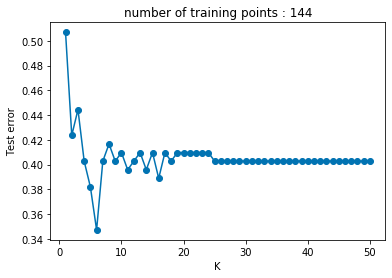

In [74]:
errorCurve = tpsource.ErrorCurve(k_range=range(1,51))
errorCurve.fit_curve(X4[::2], y4[::2], X4[1::2], y4[1::2])
errorCurve.plot()

On voit que le nombre de voisins optimal $k$ se situe autour de 7.

# 10)

Tracez les différentes courbes d’erreur en fonction du paramètre k = (1, 2, . . . , 50) sur le jeu de données #4, pour des nombres d’échantillons d’entrainement n prenant les valeurs 100, 200, 500 à 1000. Cette fois, tirez l’ensemble d’apprentissage et l’ensemble de test indépendamment et de même taille. Quelle est la meilleure valeur de k ? Est-ce la même pour les différents datasets ? Vous pourrez utiliser la classe fournie ErrorCurve. Pour n = 1000 visualisez les données et la règle de décision sur le même graphique. (Vous pouvez utiliser la fonction frontiere_new.)

Pour des raisons d'interprétabilité des résultats, on utilisera l'écart type avec une valeur de 10%

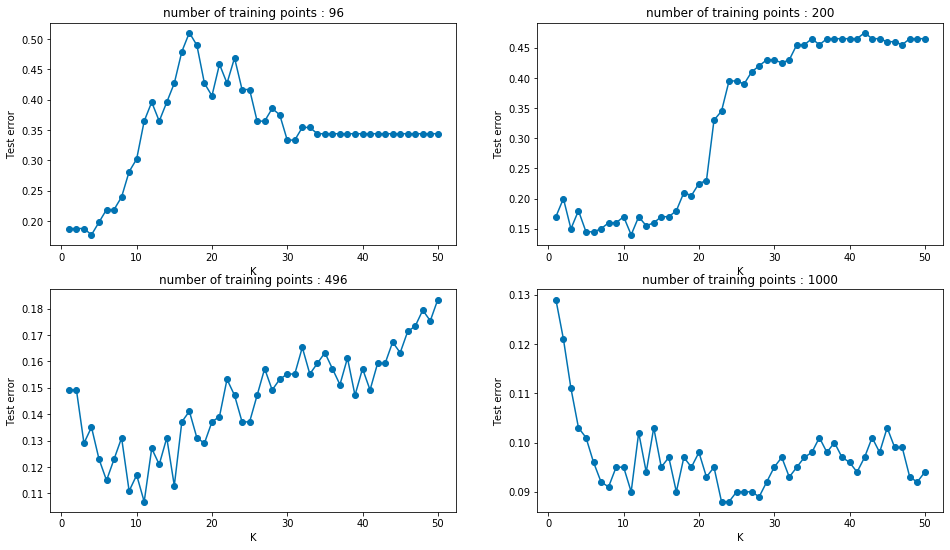

In [75]:
plt.figure(figsize=(16,9))
for n in [100, 200, 500, 1000]:
    errorCurve = tpsource.ErrorCurve(k_range=range(1,51))
    sigma = 0.1
    X, y = tpsource.rand_checkers(n, n, sigma)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    errorCurve.fit_curve(X_train, y_train, X_test, y_test)
    plt.subplot(221+[100, 200, 500, 1000].index(n))
    errorCurve.plot()

La meilleure valeur de $k$ est différente pour les différentes tailles d'échantillon.

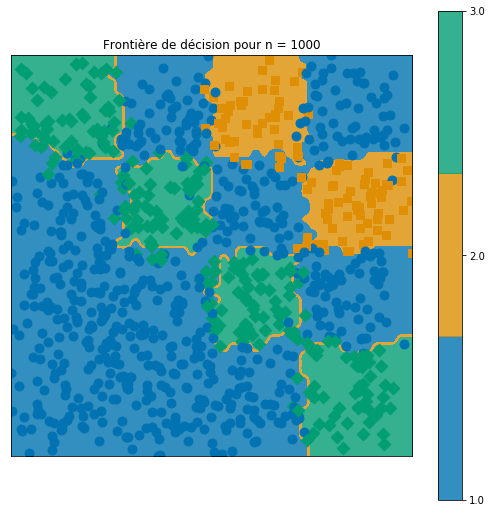

In [76]:
clf = KNeighborsClassifier(n_neighbors= 10)
clf.fit(X_train, y_train)
plt.figure(figsize=(9,9))
plt.title("Frontière de décision pour n = 1000")
tpsource.frontiere_new(lambda x: clf.predict(x.reshape(1,-1)), X_test, y_test)

On note une classification bonne visuellement, l'algorithme KNN semble adapté pour ces données.

# 11)

A votre avis, quels sont les avantages et les inconvénients de la méthode des plus proches voisins :
temps de calcul ? passage à l’échelle ? interprétabilité ?

<b>Avantages</b>

Algorithme intuitif<br>
Aisément paramétrisable<br>
Le nombre de classes peut être quelconque<br>
Comme nous l'avons vu, des variantes peuvent être apportées avec plusieurs définitions des poids

<b>Inconvénients</b>

Algo glouton:<br>
- Distances calculées pour chaque points d'entraînement
- Tri des colonnes<br>
--> <u>problème de passage à l'échelle</u><br>
Instabilité: comment choisit-on $k$? Ainsi que la méthode de calcul de la distance?

# 12)

Étudiez la base digits de scikit-learn. On pourra se référer à http://scikit-learn.org/stable/_downloads/plot_digits_classification.py pour le chargement et la manipulation de la base de données. Pour de plus amples informations sur la nature de la classe 'Bunch' (une sous-classe de dictionnaire, on se reportera à la documentation sur la classe 'dict' : http://docs.python.org/2/library/stdtypes.html#mapping-types-dict. Décrivez la nature et le format des données (précisément), affichez un exemple. Tracez l’histogramme pour des classes. Coupez l’échantillon en deux parties de même taille et utilisez la première partie pour l’apprentissage et la deuxième pour le test. Appliquez la méthode aux données issues de la base digits pour un choix de k ≥ 1 (e.g., k = 30) et indiquez le taux d’erreur.

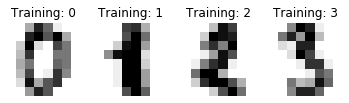

In [77]:
digits = datasets.load_digits()

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)


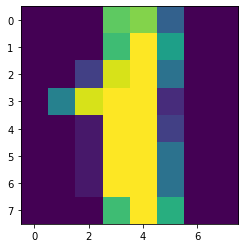

In [78]:
plt.imshow(digits['images'][1])

Cette bibliothèque nous donne accès à des images pixelisées.

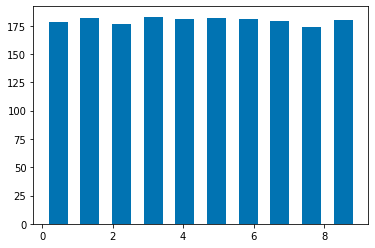

In [79]:
plt.hist(digits['target'], rwidth= 0.6);

Les classes sont équitablement réparties.

In [80]:
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [81]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1)) # Transformation des données en matrice (samples, feature)

clf=KNeighborsClassifier(n_neighbors=30)

clf.fit(data[:n_samples // 2], digits.target[:n_samples // 2])

expected= digits.target[n_samples // 2:]
predicted = clf.predict(data[n_samples // 2:])

print("Taux d'erreur: {}".format(round(1-metrics.r2_score(expected, predicted),3)))

Taux d'erreur: 0.172


# 13)

Estimez la matrice de confusion $(P{Y = i, C_k (X) = j})$ $i, j$ associée au classifieur $C_k$ ainsi obtenu et visualisez celle-ci. Pour la manipulation de telles matrices avec scikit-learn, on pourra consulter http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [82]:
print("Matrice de confusion:\n%s" % metrics.confusion_matrix(expected, predicted))

Matrice de confusion:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 82  5  1  0  1  0  0  0  2]
 [ 1  0 79  6  0  0  0  0  0  0]
 [ 0  0  0 81  0  3  0  4  1  2]
 [ 2  0  0  0 87  0  0  2  1  0]
 [ 0  0  0  0  0 85  3  0  0  3]
 [ 0  0  0  0  0  0 91  0  0  0]
 [ 0  0  1  0  0  0  0 88  0  0]
 [ 0  6  1  6  0  4  1  1 68  1]
 [ 1  0  0  4  0  2  0  0  1 84]]


# 14)

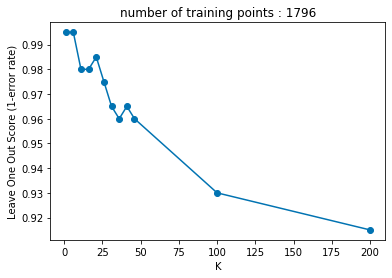

In [83]:
k_list = [1,6,11,16,21,26,31,36,41,46,100,200]

CV_digits = tpsource.LOOCurve(k_range = k_list)
CV_digits.fit_curve(data, digits.target)
CV_digits.plot()

Une méthode pour choisir l'hyperparamètre $k$ peut être d'utiliser la validation croisée afin de choisir le meilleur $k$. LOOCurve trace les résultat en fonction de $k$ en entrainant sur toutes chaque <i>fold</i>.

On constate que le meilleur score est obtenu pour k = 6 ou k = 1

# ADL

# 15)

En utilisant la formule de Bayes donner la formule des probabilités a posteriori

$ \mathbb{P}\{Y=+1|X=x\} = \frac{\mathbb{P}\{Y=+1, X=x\}}{\mathbb{P}\{X=x\}}$

$ \mathbb{P}\{Y=+1|X=x\} = \frac{\mathbb{P}\{X=x|Y=+1\} \mathbb{P}\{Y=+1\} }{\mathbb{P}\{X=x\} }$

$ \mathbb{P}\{Y=+1|X=x\} = \frac{f_+ \pi_+}{\mathbb{P}\{X=x\} }$

$ \mathbb{P}\{Y=+1|X=x\} = \frac{f_+ \pi_+}{(\mathbb{P}\{X=x|Y=+1\}\mathbb{P}\{Y= +1\} + \mathbb{P}\{X=x|Y=-1\}\mathbb{P}\{Y= -1\}) }$

$\mathbb{P}\{Y=+1|X=x\} = \frac{f_+ \pi_+}{(f_+\pi_+ + f_-\pi_-)}$

De même,

$ \mathbb{P}\{Y=-1|X=x\} = \frac{f_- (1-\pi_+)}{\mathbb{P}\{X=x\} }$

$\mathbb{P}\{Y=-1|X=x\} = \frac{f_- (1-\pi_+)}{(f_+\pi_+ + f_-\pi_-)}$

# 16)

Exprimer le log-ratio des deux classes

$\log\left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) = \log\left(\frac{f_+\pi_+}{f_-(1-\pi_+)}\right)$

Or, on a:

$\frac{f_+}{f_-} =  exp\left\{\frac{1}{2}\left[(x-\mu_-)^T \Sigma^{-1} (x-\mu_-) - \left((x-\mu_+)^T \Sigma^{-1} (x-\mu_+)\right)  \right]\right\}$

$ \frac{f_+}{f_-} =  exp\left\{-x^T\Sigma^{-1}\mu_-  + x^T\Sigma^{-1}\mu_+ + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ \right\}$

$\frac{f_+}{f_-} =  exp\left\{x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ \right\}$

Ainsi,

$\log\left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) = x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+  + \log\left(\frac{\pi_+}{(1-\pi_+)}\right)$

# 17)

Si la classe est 1 alors on a l'inégalité suivante:
$$\log(\frac{\mathbb{P}{ ( Y = 1 | X = x ) }}{\mathbb{P}{ ( Y =- 1 | X = x ) }}) > 1$$
Donc, d'après la question précédente:
$$ x^{T} \Sigma^{-1}(\mu_{+}-\mu_{-}) -\frac{1}{2} \mu^{T}_{+}\Sigma^{-1}\mu_{+}    
+ \frac{1}{2} \mu^{T}_{-}\Sigma^{-1}\mu_{-} - \log(1-\frac{m}{n}) + \log(\frac{m}{n}) > 0$$
d'où
$$ x^{T} \Sigma^{-1}(\mu_{+}-\mu_{-}) >\frac{1}{2} \mu^{T}_{+}\Sigma^{-1}\mu_{+}    
- \frac{1}{2} \mu^{T}_{-}\Sigma^{-1}\mu_{-} + \log(1-\frac{m}{n}) - \log(\frac{m}{n})  $$
Idem pour -1.

# 18)

Écrivez votre propre classe LDAClassifier avec les méthodes d’apprentissage fit et de classification predict.

In [56]:
class LDAClassifier():#BaseEstimator, ClassifierMixin):
    
    def fit(self, X, y):       
        
        X_p = X[y == 1, :]
        X_m = X[y == -1, :]
        
        X_p_x1 = X_p[:,0]
        X_p_x2 = X_p[:,1]
        X_m_x1 = X_m[:,0]
        X_m_x2 = X_m[:,1]
        
        n = len(X)
        m = len(X_p)
        
        mean_p_x1 = np.mean(X_p_x1)
        mean_p_x2 = np.mean(X_p_x2)
        mean_p = np.array([mean_p_x1,mean_p_x2]) # mu_plus (estimé)
        cov_p = np.cov(np.transpose(X_p))
        

        mean_m_x1 = np.mean(X_m_x1)
        mean_m_x2 = np.mean(X_m_x2)
        mean_m = np.array([mean_m_x1,mean_m_x2]) # mu_minus (estimé)
        cov_m = np.cov(np.transpose(X_m))
        
        cov_est = (1/(n-2))*( (m-1)* cov_p + (n-m-1)* cov_m) # sigma (estimé)
        inv_cov_est = np.linalg.inv(cov_est)
        
        a1 = np.dot(np.transpose(mean_p),inv_cov_est)
        a2 = np.dot(np.transpose(mean_m),inv_cov_est)
        
        # 2nd term in inequality
        self.alpha = 0.5*(np.dot(a1,mean_p)  - 0.5*np.dot(a2,mean_m)) + np.log(1- m/n) - np.log(m/n)
        # 1st term in inequality
        self.beta =  np.dot(inv_cov_est,mean_p-mean_m)
        
        return self
    
    def predict(self, X):
        
        y_=[]
        
        for i in range(len(X)):
            X_pred = X[i]
            beta = np.dot(np.transpose(X_pred), self.beta)
            if (beta>self.alpha):
                Y_pred = 1
            else:
                Y_pred = -1
            y_.append(Y_pred)
        return np.array(y_)

# 19)

Importez le module sklearn.discriminant_analysis qui contient en particulier la classe LinearDiscriminantAnalysis qui nous servira dans la suite.

In [91]:
# classification peu linéaire
n1 = 50
n2 = 50
sigmas1 = 1.
sigmas2 = 5.
X3, y3 = tpsource.rand_clown(n1, n2, sigmas1, sigmas2)

In [92]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.8, random_state=1)

In [93]:
my_LDAClassifier = LDAClassifier()
my_LDAClassifier.fit(X3_train, y3_train)
sk_LDAClassifier = LinearDiscriminantAnalysis()
sk_LDAClassifier.fit(X3_train, y3_train)
all(my_LDAClassifier.predict(X3_test) == sk_LDAClassifier.predict(X3_test))

True

On retrouve bien les résultats de la bibliothèque sklearn

In [90]:
print("Score ADL: {:.2f}".format(my_LDAClassifier.score(X3_test, y3_test)))

Score ADL: 0.36


# 20)

En utilisant votre classe LDAClassifier, visualisez la règle de classification pour les jeux de données #1 et #3. (Vous pouvez utiliser la fonction frontiere_new.) Discutez l’efficacité de la méthode dans ces deux cas.

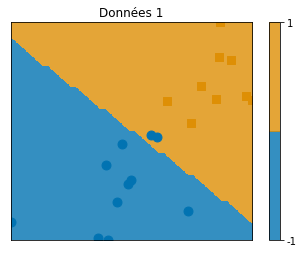

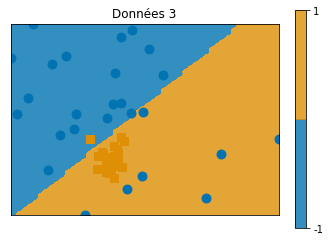

In [91]:
for X, y ,i in zip([X1,X3],[y1,y3], [0,1]):
    my_LDAClassifier = LDAClassifier()
    my_LDAClassifier.fit(X[::2],y[::2])
    plt.title("Données "+str((lambda i: 2*i+1)(i)))
    tpsource.frontiere_new(lambda x: my_LDAClassifier.predict(x.reshape(1,-1)), X[1::2], y[1::2])
    plt.show()

On peut en déduire que l'ADL est efficace si les données sont linéairement séparables.

# Régression logistique

# 21)

Appliquez la classification par régression logistique sur les données rand_bi_gauss. Comparer les résultats avec la LDA, notamment lorsque une classe est beaucoup plus petite que l’autre (a beaucoup moins d’observations). On parle alors de classes déséquilibrées.

In [92]:
log_reg = linear_model.LogisticRegression(solver='liblinear')
log_reg.fit(X3, y3)
n1 = 100
n2 = 1000
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X1, y1 = tpsource.rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)
log_reg.fit(X1[::2], y1[::2])
log_reg.score(X1[1::2], y1[1::2])

0.9763636363636363

In [93]:
my_LDAClassifier.fit(X1[::2], y1[::2])
my_LDAClassifier.score(X1[1::2], y1[1::2])

0.9727272727272728

On obtient des résultats sensiblement égaux.

# 22)

À quoi correspond la variable coef_ du modèle ? intercept_ ?

In [94]:
print(log_reg.coef_)
print(log_reg.intercept_)

[[2.05915853 1.84862165]]
[-1.64830684]


<i>coef</i> correspond au vecteur normal de la droite séparatrice. <i>intercept</i> son ordonnée à l'origine.

# 23)

Utiliser la fonction frontiere_new pour visualiser la frontière de décision.

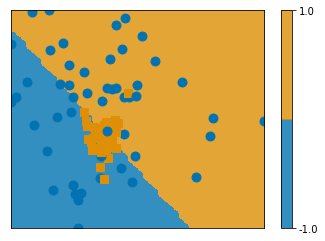

In [95]:
tpsource.frontiere_new(lambda x: log_reg.predict(x.reshape(1,-1)), X3, y3)

Comme constaté précédemment, la regression logistique n'est pas adaptée si la séparation des données n'est pas linéaire.

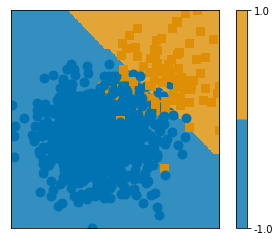

In [96]:
log_reg.fit(X1, y1)
tpsource.frontiere_new(lambda x: log_reg.predict(x.reshape(1,-1)), X1, y1)

# 24)

Appliquez la classification par régression logistique à des données issues de la base digits. Comme
précédemment, coupez l’échantillon en deux parties de même taille et utilisez la première partie
pour l’apprentissage et la deuxième pour tester. Indiquez le taux d’erreur.

In [98]:
log_reg = linear_model.LogisticRegression(solver='liblinear', multi_class='ovr')
log_reg.fit(data[::2], digits['target'][::2])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [99]:
print("Taux d'erreur: {:.3f}".format(1-log_reg.score(data[1::2], digits['target'][1::2])))

Taux d'erreur: 0.060
